# Logistic Regression

Ref: Chap 4 of Mar18

https://cfteach.github.io/brds/referencesmd.html

In [1]:
!pip install pymc3 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 19.1 MB/s 
     |████████████████████████████████| 1.8 MB 81.8 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=f347f18ecf926b37515c2d31ec00e6049019f2096ed82587e7747515ef4ee071
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc


In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import seaborn as sns
import scipy.stats as stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
import arviz as az
import requests
import io 

In [3]:
az.style.use('arviz-darkgrid')

## The Iris Dataset

In [28]:
target_url = 'https://raw.githubusercontent.com/cfteach/brds/main/datasets/iris.csv' 

download = requests.get(target_url).content
iris = pd.read_csv(io.StringIO(download.decode('utf-8')))

iris.head()

iris['species']

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: object

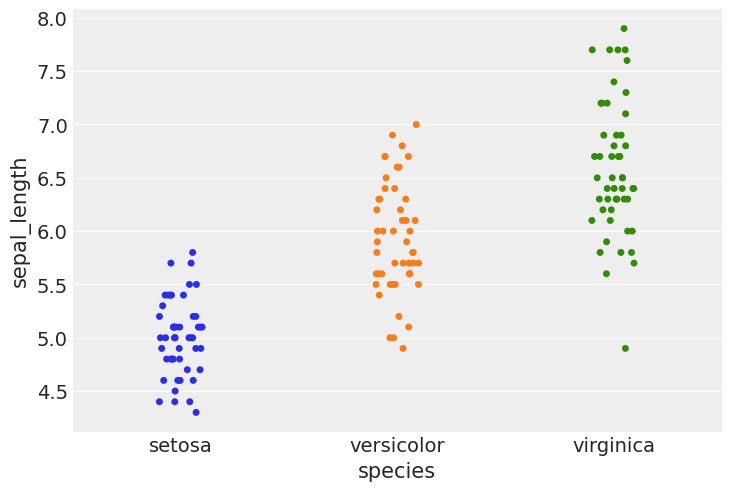

In [8]:
#using stripplot function from seaborn 

sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)



/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self._figure.tight_layout(*args, **kwargs)


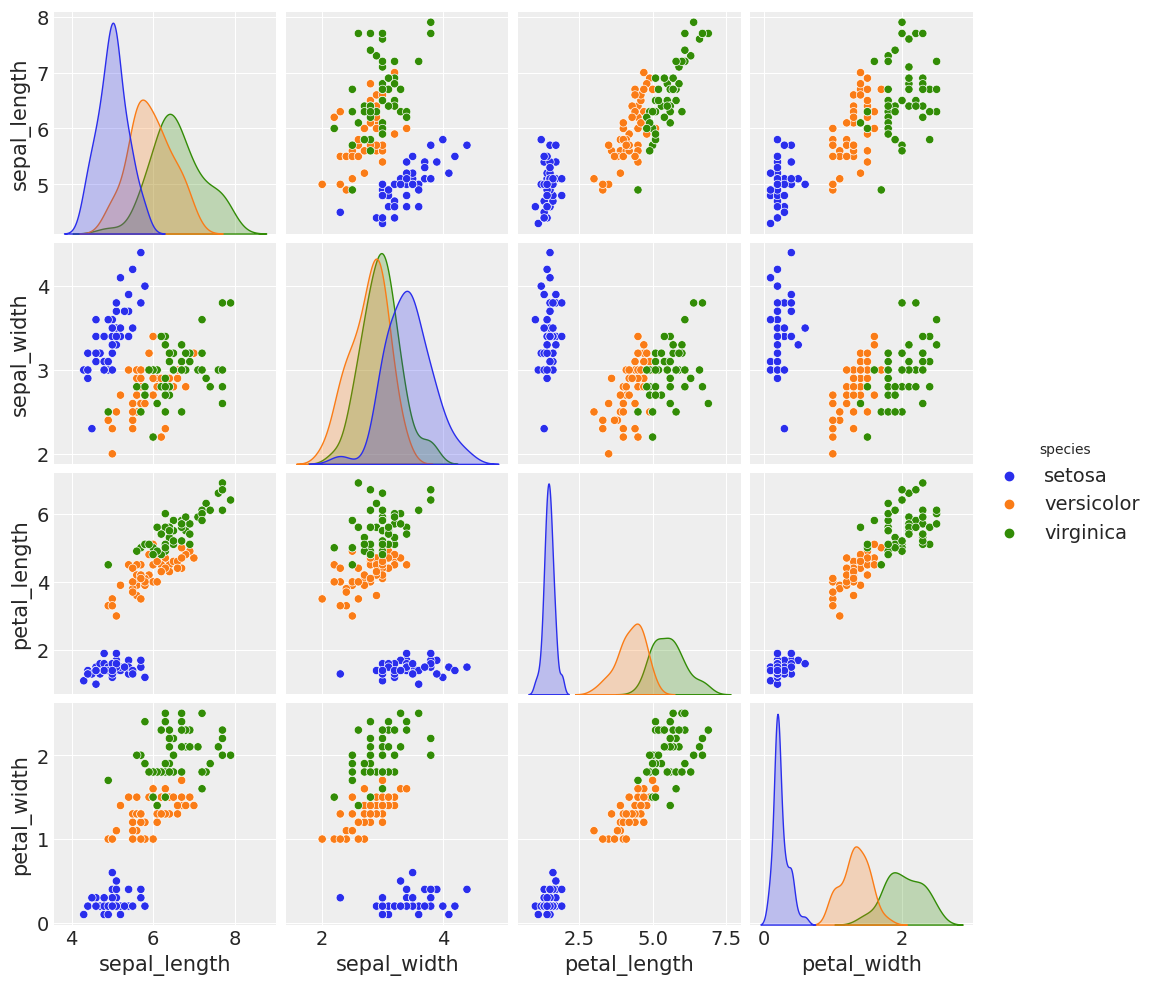

In [9]:
sns.pairplot(iris, hue='species', diag_kind='kde')

## Multiple logistic regression

In [5]:
df = iris.query("species == ('setosa', 'versicolor')") 
y_1 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_1 = df[x_n].values



In [6]:
print(np.shape(x_1), type(x_1))
t_l = x_1.tolist()
print(np.shape(t_l), type(t_l))


(100, 2) <class 'numpy.ndarray'>
(100, 2) <class 'list'>


In [7]:
with pm.Model() as model_1: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 

    x__1 = pm.Data('x', x_1)
    y__1 = pm.Data('y', y_1)
     
    μ = α + pm.math.dot(x__1, β)
    
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ))) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x__1[:,0])
     
    yl = pm.Bernoulli('yl', p=θ, observed=y__1) 
 
    trace_1 = pm.sample(2000, tune=4000, return_inferencedata=True, target_accept=0.9)

Text(0, 0.5, 'sepal_width')

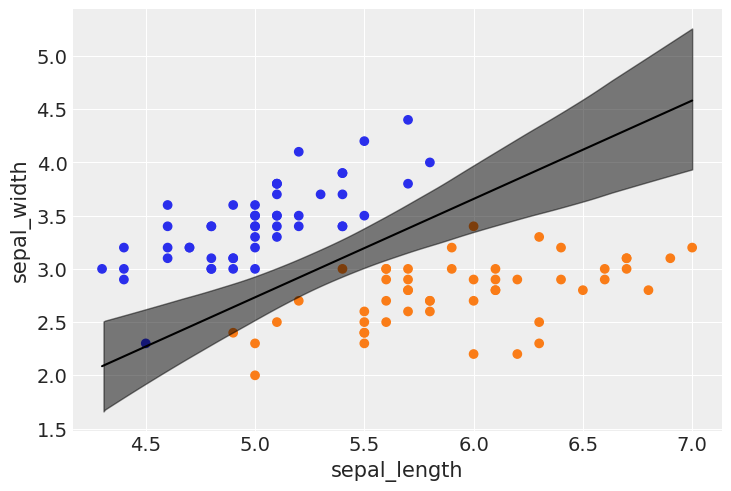

In [ ]:
idx = np.argsort(x_1[:,0]) 


bd_mean = trace_1.posterior['bd'].mean(axis=0).mean(axis=0)


plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_0]) 

bd = bd_mean[idx]

plt.plot(x_1[:,0][idx], bd, color='k'); 


az.plot_hdi(x_1[:,0], trace_1.posterior['bd'], color='k')
 
    
plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])



## Diagnostics of MCMC

We now understand that the sampling is done with Markov Chain Monte Carlo techniques. 

Let's check the quality of our results by doing some diagnostics.

Good results are produced by a **"Good Mixing"** in our chain. 

Viceversa, if we observe divergences or patterns that deviate from randomic behaviour (yes, we ideally like "white noise" in our chains), we will say that we had a **"Bad Mixing"**.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f08396949a0>,
      dtype=object)

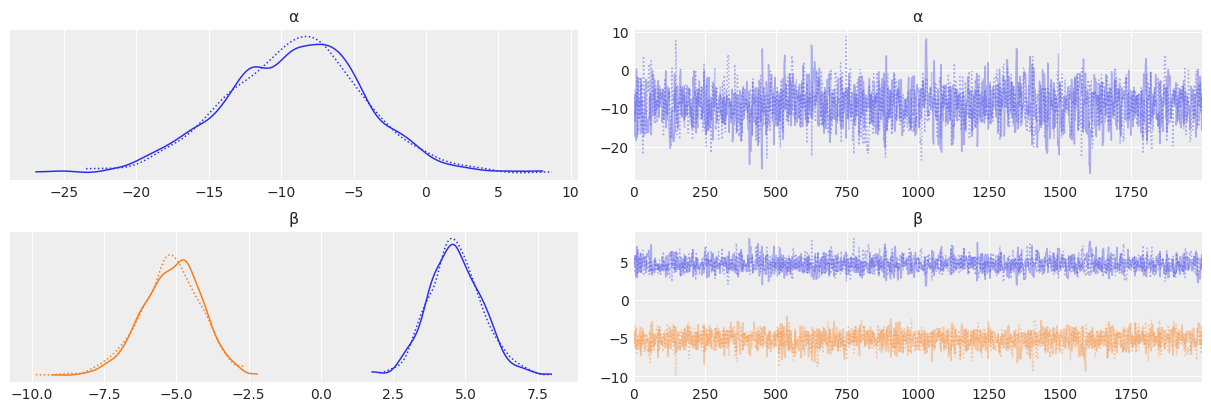

In [26]:
az.plot_trace(trace_1, varnames, divergences='top')

> check1: If divergences are present, they will be higlihted with bars on top of the plots, so to make them easy to identify 

> check2: You want to check that the 2 (or more, if multiple CPUs were available) chains produce distributions that overlaps; different behavior would mean instead not 

> check3: are there patterns in our chains or do they look random? Remember: random is good. Patterns may emerge for example when the distribution we are sampling are multimodal, and we get stuck for a while in one of the peaks. A good mixing chain, even in case of a multimodal distribution, would reflect in a random chain where patterns are not identifiable.  

## Autocorrelation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f083f04d160>,
      dtype=object)

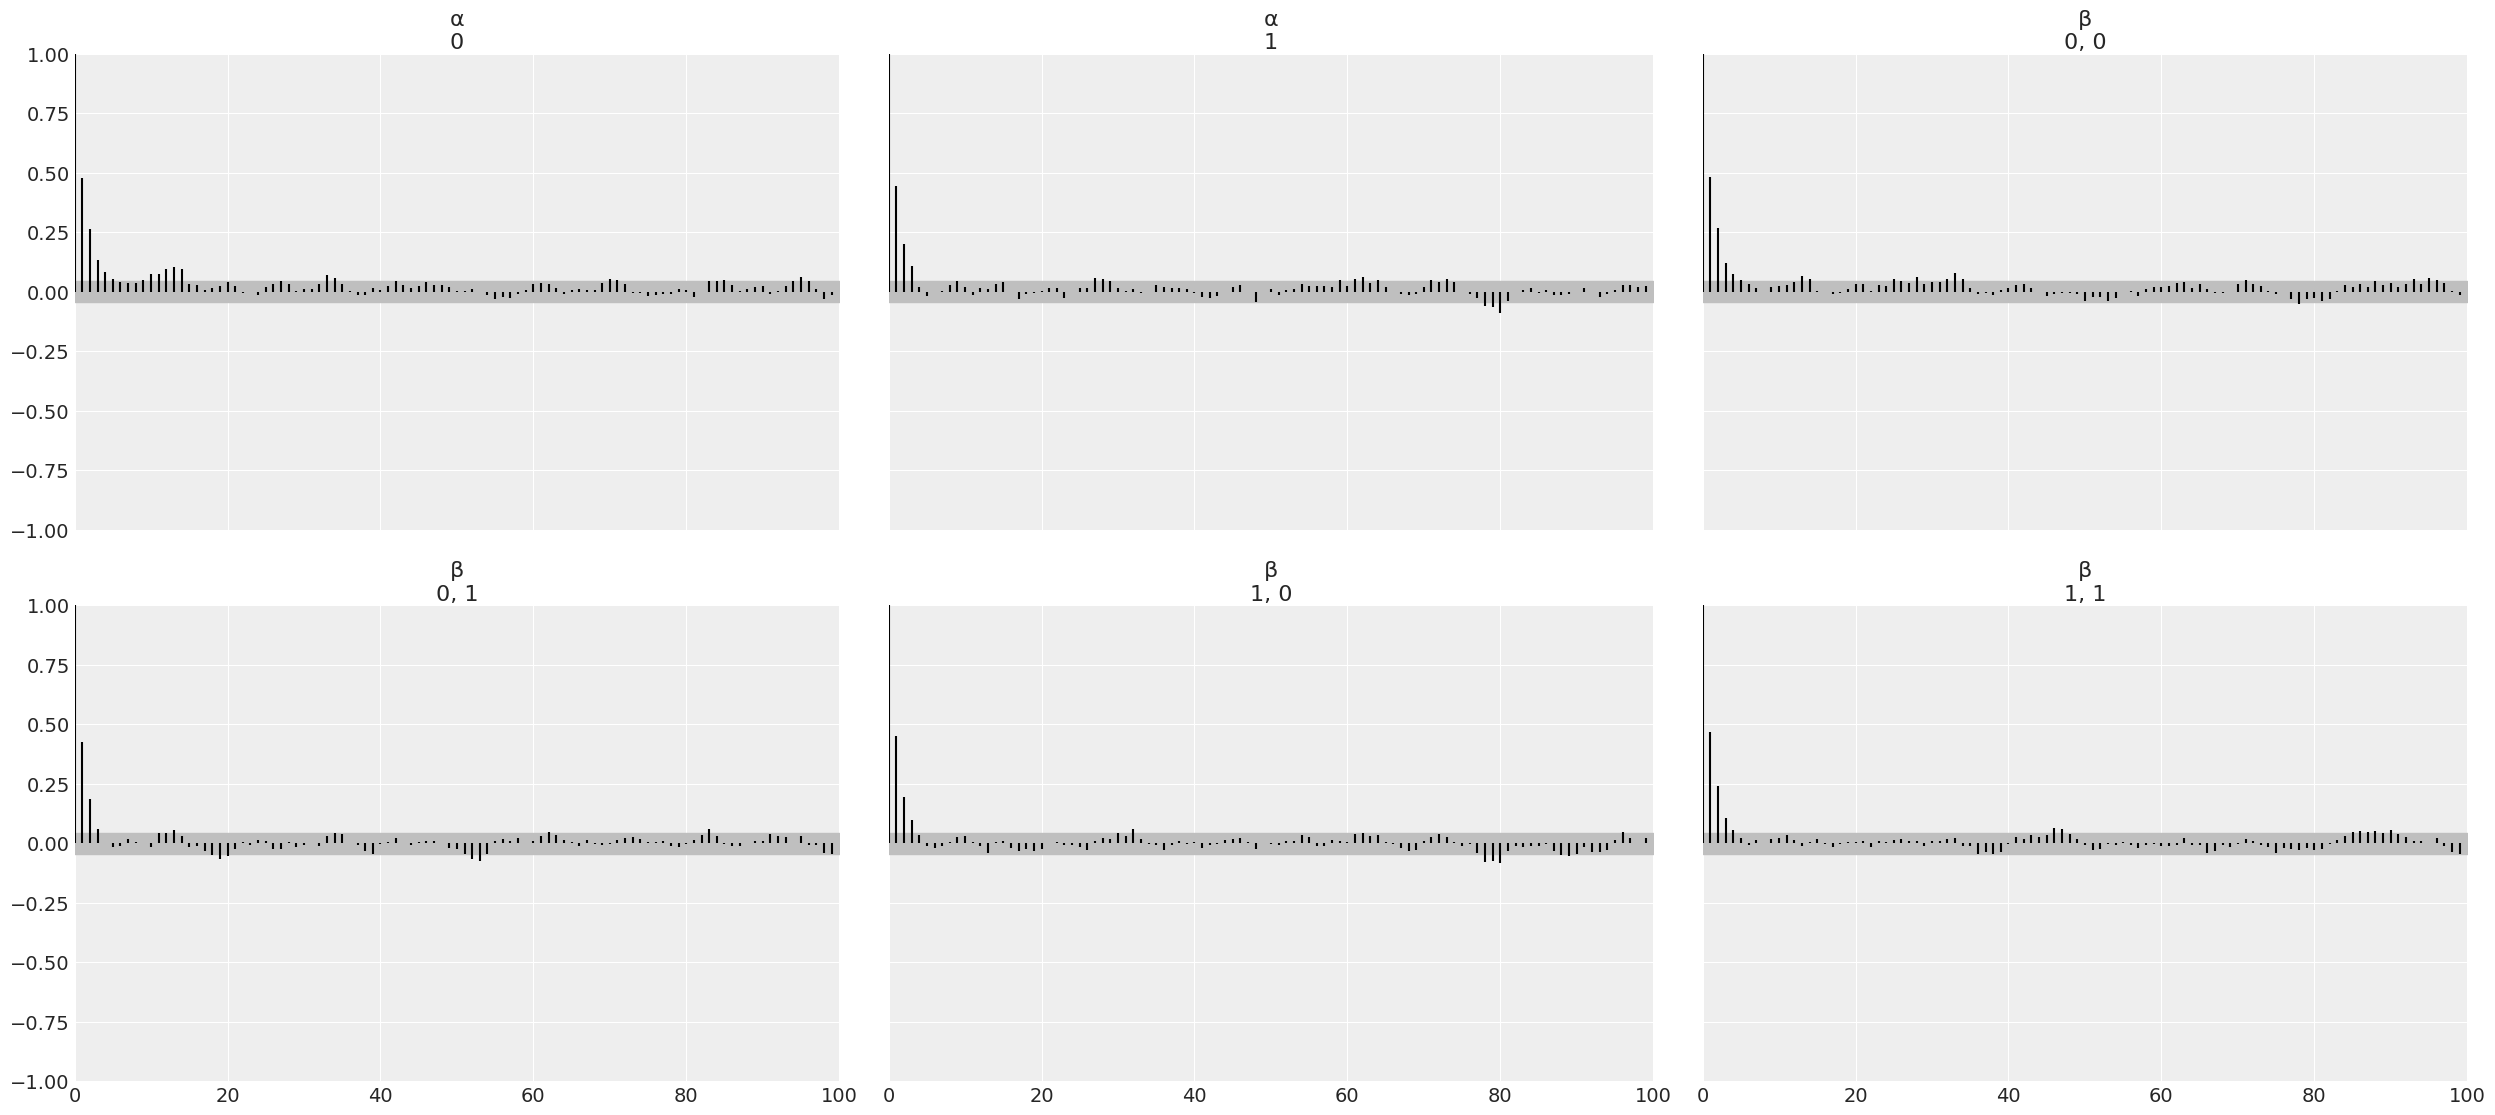

In [27]:
az.plot_autocorr(trace_1, var_names=varnames)

> Notice that ideally, we do not want to see autocorrelation. In practice, we want samples that quickly drop to low values of autocorrelation.

In [13]:
az.summary(trace_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-9.070,4.827,-18.544,-0.444,0.136,0.104,1286.0,1170.0,1.0
β[0],4.653,0.914,3.011,6.435,0.024,0.017,1421.0,1249.0,1.0
β[1],-5.184,1.033,-7.081,-3.231,0.027,0.019,1492.0,1311.0,1.0
θ[0],0.037,0.024,0.003,0.080,0.001,0.000,2087.0,2183.0,1.0
θ[1],0.152,0.070,0.039,0.284,0.001,0.001,2451.0,2470.0,1.0
...,...,...,...,...,...,...,...,...,...
bd[95],3.375,0.122,3.159,3.614,0.003,0.002,2078.0,2270.0,1.0
bd[96],3.375,0.122,3.159,3.614,0.003,0.002,2078.0,2270.0,1.0
bd[97],3.837,0.212,3.471,4.256,0.006,0.004,1381.0,1475.0,1.0
bd[98],2.822,0.100,2.635,3.008,0.002,0.001,2851.0,2666.0,1.0


- **ess=Effective Sample Size**  a sample with autocorrelation has less information than a sample of the same size without autocorrelation; autocorrelation has the detrimental effect of reducing the number of effective samples (you can observe this at the bulk or tail of the chain)

> Recipe: the effective sample size should be close to the actual sample size

- **mcse=Monte Carlo Standard Error** [1] When using MCMC methods we introduce an additional layer of uncertainty as we are approximating the posterior with a finite number of samples. We can estimate the amount of error introduced using the Monte Carlo standard error (MCSE), which is based on Markov chain central limit theorem. In other words, this is an estimation of the error introduced by the sampling method. The standard error of the mean x of n blocks (where each block is just a portion of the trace) is:

<center>
$mc_{error} = \frac{\sigma(x)}{\sqrt{n}}$
</center>

> This error should be below the precision we want in our results. We should check the MCSE after the ESS. And you need to know what is the required precision. Otherwise is of no use.

- **r_hat** The idea of this test is to compute the variance between chains with the variance within chains. Ideally, we should expect a value of 1. 

> Recipe: if it is below 1.1 is OK




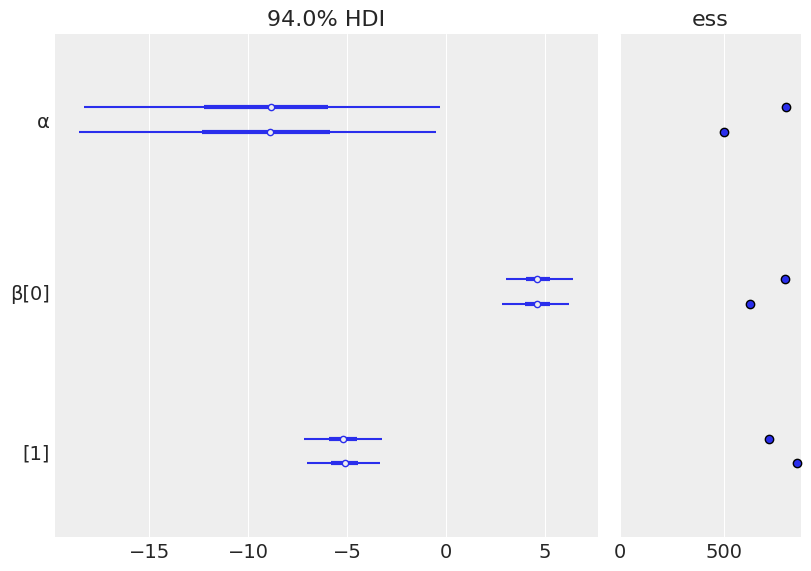

In [22]:
varnames = ['α','β'] 
# ess: Effective Sample Size
az.plot_forest(trace_1, var_names=varnames, ess=True);

> Recipe (forest plot): there is evidence of good mixing if the two (depending on how many CPUs were available) chains produce similar results.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f08420bff10>,
      dtype=object)

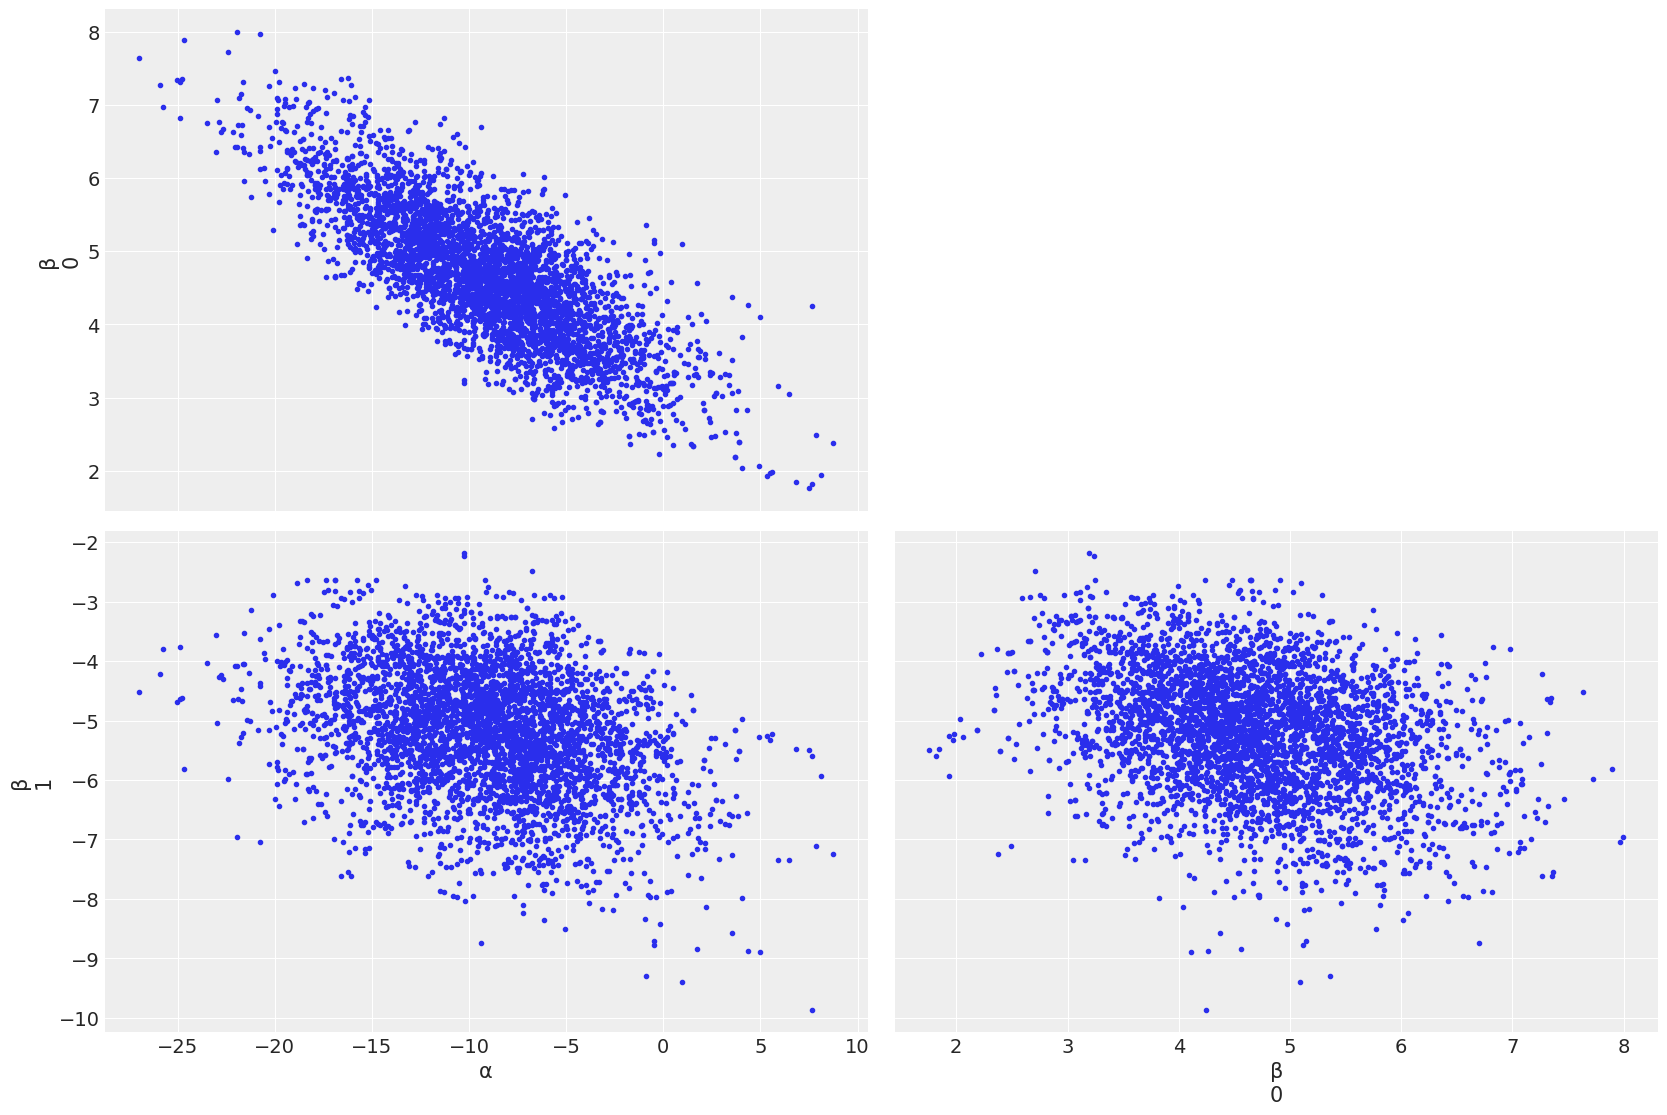

In [23]:
az.plot_pair(trace_1, var_names=['α','β'])

> If divergences are preesent, they are shown as black/orange points

> To cure/get rid of divergences, a recipe could be:

1.   Increase the number of tuning step **pm.sample(tuning=1000)**
2.   Increase the value of **target_accept**; this parameter, whose default value is 0.8, can be changed to 0.85 or 0.90. Intuitively, this is related to the acceptance in our sampling. Changing this parameter under the hood implies tuning another parameter called **step_size**, which is the number of steps per sample in the NUTS sampling. NUTS is a No-U-Turn Sampler, an MCMC algorithm that resemble Hamiltonian Monte Carlo techniques, it has a larger acceptance rate and works with continuous distribution. If you want to read more, see [2]. The trade-off is that each step is more likely to be accepted but more compute intensive. 

> N.B. PyMC combines NUTS + METROPOLIS for sampling: NUTS is used for continuous parameters, METROPOLIS for discrete



## References

[1] Martin Osvaldo A, Kumar Ravin; Lao Junpeng" *Bayesian Modeling and Computation in Python Boca Ratón*, 2021. ISBN 978-0-367-89436-8, https://bayesiancomputationbook.com/ 

[2] Martin Osvaldo: Bayesian Analysis with Python: Introduction to statistical modeling and probabilistic programming using PyMC3 and ArviZ. Packt Publishing Ltd, 2018. URL: https://github.com/PacktPublishing/Bayesian-Analysis-with-Python-Second-Edition.